### LLM Analize Petro Videos

In [2]:
import os
from pydantic import BaseModel, Field
import json
from datetime import datetime
import time


import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
import emoji
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import ast
from scipy.stats import norm
import networkx as nx
from collections import Counter
from itertools import combinations

In [2]:
class VideoResponseFormat(BaseModel):
    """
    The response format for the video transcription analisys.
    """
    score: str = Field(
        description="Score from 1 to 5, where 1 is terrible and 5 is excellent."
    )
    topic: list[str] = Field(
        description="List with at least one or max three main topics of the video.",
        examples=[
            "Security",          # Public safety, crime, police effectiveness
            "Mobility",          # Public transport, traffic, infrastructure
            "Public Services",   # Water, electricity, waste management
            "Urban Development", # Housing, urban planning, public spaces
            "Education",         # Schools, literacy programs, educational access
            "Healthcare",        # Hospitals, clinics, public health initiatives
            "Corruption",        # Transparency, anti-corruption measures
            "Social Inequality", # Poverty, social programs, inclusion
            "Environment",       # Pollution, green spaces, sustainability
            "Economy",           # Local business, employment, economic growth
            "Public Image",      # Mayor’s reputation, media presence, scandals
            "Elections",         # Campaigning, voter engagement, electoral integrity
            "Infrastructure",    # Roads, bridges, public works
            "Cultural Heritage", # Arts, festivals, historical preservation
            "Citizen Participation", # Community engagement, participatory governance
            "Post-Conflict Integration" # Reintegration of ex-combatants, peacebuilding
        ]
    )

In [10]:
load_dotenv("./.env")
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [11]:
client = OpenAI(
    api_key=GROK_API_KEY,
    base_url="https://api.x.ai/v1",
)

In [7]:
def video_analisys_llm_api(row) -> dict:
    """
    Call the Grok API to get the sentiment and topic of the video transcription.

    Args:
        row (dict): A dictionary containing the video data like:
            video_id (str): The ID of the video.
            video_timestamp (str): The timestamp of the video.
            hashtag (str): The hashtag associated with the video.
            author_username (str): The username of the author of the video.
            video_description (str): The description of the video.
            video_transcription (str): The transcription of the video.
    Returns:
        dict: The sentiment and topic of the transcription.
    """
    try:
        parsed_date = datetime.strptime(row['video_timestamp'], "%Y-%m-%dT%H:%M:%S")
        time.sleep(1)  # Avoid rate limit issues
        grok_request = client.beta.chat.completions.parse(
            model="grok-3-mini-beta",
            messages=[
                {
                    "role": "system",
                    "content": f"I'm researching about Bogotá's mayor, Carlos Fernando Galán, based in the trasncription and its description, consider the user to make decisions if necessary or if you need more information, give me the sentiment the user is trying to share in a scale of 1-5 and also give me the main topics, you can use words from the example or a different word if you think it is needed to describe the topic of the video, if you can't determine the topic return NT or return NA if you think text isn't related to Carlos Fernando Galán",
                },
                {
                    "role": "user", 
                    "content": f"user:{row["author_username"]},\ndescription:{row["video_description"]},\ntranscription:{row["video_trasncription"]}"
                }
            ],
            response_format=VideoResponseFormat,
            reasoning_effort="low",
            temperature=0.5,
        )
    except Exception as e:
        print(f"Error trying to call Grok API: {e}")
        return {"score": "NA", "topic": ["NA"]} | {'date': parsed_date, 'video_id': row['video_id'], "video_description":row["video_description"], 'hashtag': row['hashtag'], 'author_username': row["author_username"], "video_transcription":row["video_trasncription"], 'llm_reasoning': str(e)}

    result = json.loads(grok_request.choices[0].message.content)
    reasoning = grok_request.choices[0].message.reasoning_content
    return result | {'date': parsed_date, 'video_id': row['video_id'], "video_description":row["video_description"], 'hashtag': row['hashtag'], 'author_username': row["author_username"], "video_transcription":row["video_trasncription"], 'llm_reasoning': reasoning}

In [8]:
def is_emoji_only(text:str) -> bool:
    """
    Check if a string contains only emojis (no letters, numbers, or other meaningful characters).
    args:
        text (str): The string to check.
    Returns:
        bool: True if the string contains only emojis, False otherwise.
    """
    if not isinstance(text, str):
        return False
    # Remove emojis and check if any non-whitespace characters remain
    text_no_emojis = emoji.replace_emoji(text, replace='')
    return len(text_no_emojis.strip()) == 0 and len(text) > 0

#### Pre analysis

In [35]:
# Load the Excel file into a DataFrame
df_videos = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\video_info_03-28-2025_0811_Galan_V2.xlsx",sheet_name='videos_data', dtype=str)
# df_videos['video_timestamp'] = pd.to_datetime(df_videos['video_timestamp'])
df_videos['video_diggcount'] = pd.to_numeric(df_videos['video_diggcount'])
df_videos['video_commentcount'] = pd.to_numeric(df_videos['video_commentcount'])
df_videos = df_videos.drop_duplicates(subset=['video_id']).dropna()

In [36]:
# Filter out rows where 'video_description' and 'video_transcription' are both NaN
df_videos = df_videos.dropna(subset=['video_description', 'video_trasncription'], how='all')

In [37]:
# Filter out rows where video_description is emoji-only and video_trasncription is empty
mask = (
    (df_videos['video_description'].apply(is_emoji_only) ) & (df_videos['video_trasncription'].isna() | df_videos['video_trasncription'].eq(''))
)
df_videos = df_videos[~mask]

In [19]:
def calculate_monthly_engagement(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate total and average likes/comments per month.

    Parameters:
    - df: DataFrame with 'date', 'likecount', 'commentcount', 'videoid' columns.

    Returns:
    - DataFrame grouped by month with totals and averages.
    """
    # Ensure datetime format
    df = df.copy()
    df['video_timestamp'] = pd.to_datetime(df['video_timestamp'])

    # Set date as index
    df.set_index('video_timestamp', inplace=True)

    # Group by month
    monthly = df.groupby(pd.Grouper(freq='M')).agg(
        total_likes=('video_diggcount', 'sum'),
        total_comments=('video_commentcount', 'sum'),
        avg_likes_per_video=('video_diggcount', 'mean'),
        avg_comments_per_video=('video_commentcount', 'mean'),
        total_videos=('video_id', 'nunique')
    )

    # Optional: clean index name and reset
    monthly.index.name = 'month'
    return monthly.reset_index()

In [ ]:
df_analysis = calculate_monthly_engagement(df_videos)
# df_analysis.to_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\monthly_count_Galan.xlsx", index=False)

C:\Users\ecmar\AppData\Local\Temp\ipykernel_17768\2088929162.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby(pd.Grouper(freq='M')).agg(


#### Process Video data with LLM

In [ ]:
# df_test = df_videos.sample(5, random_state=10)

In [38]:
df_sentiment = df_videos.apply(video_analisys_llm_api, axis=1)

In [39]:
df_sentiment = pd.json_normalize(df_sentiment)

In [ ]:
# Save the DataFrame to an Excel file
# df_sentiment.to_excel(r"results\video_sentiment_analysis_llm_galan_v3.xlsx", index=False, sheet_name="results", header=True)

#### Results analysis with Python

In [3]:
def count_ratings_by_month(df:pd.DataFrame, min_video_amount:int=0, month_window:int=2, span:int=10) -> pd.DataFrame:
    """
    Count the number of ratings by month and score, and calculate the average rating and percentages.
    Args:
        df (pd.DataFrame): DataFrame containing the video data with 'date', 'score' and 'total' columns.
        min_video_amount (int): Minimum number of videos to decide if apply Moving average smoothing.
        month_window (int): Number of months to consider for the rolling average.
    Returns:
        pd.DataFrame: DataFrame with the average rating and it's percentages.
    """
    
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and rate, then count
    result = df.groupby(['month', 'score']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate Average
    temp_df = df[['month', 'score']].copy()

    # Group by month and calculate mean
    avg_ratings = temp_df.groupby('month')['score'].mean().round(2)

    result['average_rating'] = avg_ratings

    # Calculate percentages for each rating by month
    for rating in range(1, 6):
        result[f"{rating}_percent"] = (result[rating] / result['total'] * 100).round(2)

    # Apply moving average smoothing for the percentages if the total number of videos is greater than the minimum amount
    if min_video_amount > 0:
        for rating in range(1, 6):
            # Apply Exponential Moving Average (EMA)
            result[f"{rating}_percent"] = np.where(result['total'] <= min_video_amount, result[f"{rating}_percent"].ewm(span=span).mean().round(2), result[f"{rating}_percent"])
            # Apply moving average smoothing
            # result[f"{rating}_percent"] = np.where(result['total'] <= min_video_amount, result[f"{rating}_percent"].rolling(window=month_window, min_periods=1).mean().round(2), result[f"{rating}_percent"])

    # Apply moving average smoothing for the average rating if the total number of videos is greater than the minimum amount
    if min_video_amount > 0:
        # Apply Exponential Moving Average (EMA)
        result['average_rating'] = np.where(result['total'] <= min_video_amount, result['average_rating'].ewm(span=span).mean().round(2), result['average_rating'])
        # Apply moving average smoothing
        # result['average_rating'] = np.where(result['total'] <= min_video_amount, result['average_rating'].rolling(window=month_window, center=True, min_periods=1).mean().round(2), result['average_rating'])
    
    return result

In [4]:
def visualize_rating_percentages(df) -> None:
    """
    Create visualizations for rating percentages by month and average rating over time.
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Get months from index
    months = df_copy.index
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 1. Stacked bar chart - Rating distribution by month
    x = np.arange(len(months))
    width = 0.8
    
    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    
    # Colors for ratings
    colors = ['#FF9999', '#FFD699', '#9999FF','#b0e69c','#11ff9a']
    
    # Create the stacked bar chart
    bottom = np.zeros(len(months))
    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        ax1.bar(x, data, width, bottom=bottom, label=label, color=colors[i])
        bottom += data
    
    ax1.set_title('Rating Distribution by Month', fontsize=14)
    ax1.set_ylabel('Percentage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(title='Rating')
    
    # 2. Line chart for average rating over time
    ax2.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC')
    
    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        ax2.text(i, val + 0.05, f"{val}", ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Rating by Month', fontsize=14)
    ax2.set_ylabel('Average Rating')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.set_ylim(min(df_copy['average_rating'])-0.5, max(df_copy['average_rating'])+0.5)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at rating 4.0 for reference
    ax2.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization - Heatmap of percentage distribution using imshow
    fig, ax = plt.subplots(figsize=(25, 6))
    
    # Prepare heatmap data
    # heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(1, 6)])
    heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(5, 0, -1)])
    
    # Create heatmap using imshow
    im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Percentage (%)')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels([f"{i}★" for i in range(5, 0, -1)])
    
    # Add text annotations to heatmap
    for i in range(5):
        for j in range(len(months)):
            text = ax.text(j, i, f"{heatmap_data[i, j]:.1f}%",
                          ha="center", va="center", color="black")
    
    plt.title('Percentage of Rating by Month', fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_rating_percentages2(df) -> None:
    """
    Create separate visualizations:
    - Rating distribution by month (stacked bar chart)
    - Average rating over time with 95% confidence interval
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Get months from index
    months = df_copy.index
    x = np.arange(len(months))

    # ----------- First Plot: Stacked Bar Chart -----------
    plt.figure(figsize=(15, 6))

    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    colors = ['#FF9999', '#FFD699', '#9999FF', '#b0e69c', '#11ff9a']
    bottom = np.zeros(len(months))

    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        plt.bar(x, data, width=0.8, bottom=bottom, label=label, color=colors[i])
        bottom += data

    plt.title('Rating Distribution by Month', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xticks(x, months, rotation=45, ha='right')
    plt.xlabel('')
    plt.legend(title='Rating')
    plt.tight_layout()
    plt.show()

    # ----------- Second Plot: Line Chart with Confidence Interval -----------

    # Estimate standard deviation using assumed binomial variance
    # p = average_rating / 5; std = sqrt(p * (1 - p) / n) * 5
    p = df_copy['average_rating'] / 5
    n = df_copy['total']  # Make sure 'total' column = number of ratings per month
    se = np.sqrt(p * (1 - p) / n) * 5
    ci_95 = 1.96 * se

    plt.figure(figsize=(15, 6))
    plt.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC', label='Average Rating')

    # Shaded area for confidence interval
    plt.fill_between(x,
                     df_copy['average_rating'] - ci_95,
                     df_copy['average_rating'] + ci_95,
                     color='#3366CC',
                     alpha=0.2,
                     label='95% Confidence Interval')

    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

    plt.title('Average Rating by Month', fontsize=14)
    plt.ylabel('Average Rating')
    plt.xticks(x, months, rotation=45, ha='right')
    plt.ylim(min(df_copy['average_rating']) - 0.5, max(df_copy['average_rating']) + 0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
df_sentiment = pd.read_excel(r"results\video_sentiment_analysis_llm_galan_v3.xlsx",sheet_name='results', dtype=str)

In [7]:
# Filter out rows where 'topic' contains 'NA'
mask = (
    (df_sentiment["topic"].str.contains("NA", na=False)) | (df_sentiment["topic"].str.contains("NT", na=False))
)
df_sentiment = df_sentiment[~mask]

In [8]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['score'] = df_sentiment['score'].astype(int)

In [9]:
# Filter out rows greater than 2022-08
df_sentiment = df_sentiment[df_sentiment['date'] >= '2023-08-01']

In [10]:
df_sentiment["topic"] = df_sentiment['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

score
5    155
4    145
3     27
2     36
1     65
Name: count, dtype: int64


<Axes: title={'center': 'Video score distribution'}>

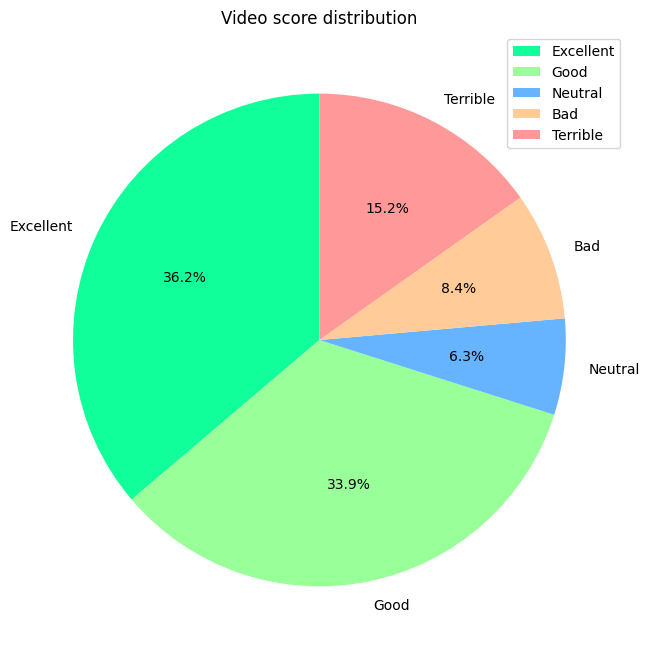

In [11]:
counts = df_sentiment["score"].value_counts()
counts = counts.sort_index(ascending=False)
print(counts)

percentage = (counts/len(df_sentiment))*100
resumen = pd.DataFrame({'counts': counts,     'percentage': percentage })
resumen['percentage'].plot.pie(autopct='%1.1f%%', figsize=(8, 8), labels=["Excellent","Good","Neutral","Bad","Terrible"], title='Video score distribution', ylabel='', legend=True, fontsize=10, startangle=90, colors=['#11ff9a','#99ff99','#66b3ff','#ffcc99','#ff9999'])

In [12]:
monthly_counts_df = count_ratings_by_month(df_sentiment.sort_values(by='date'), min_video_amount=0, month_window=3, span=10)

<Axes: title={'center': 'Total Videos by Month'}, xlabel='Month', ylabel='Amount of videos'>

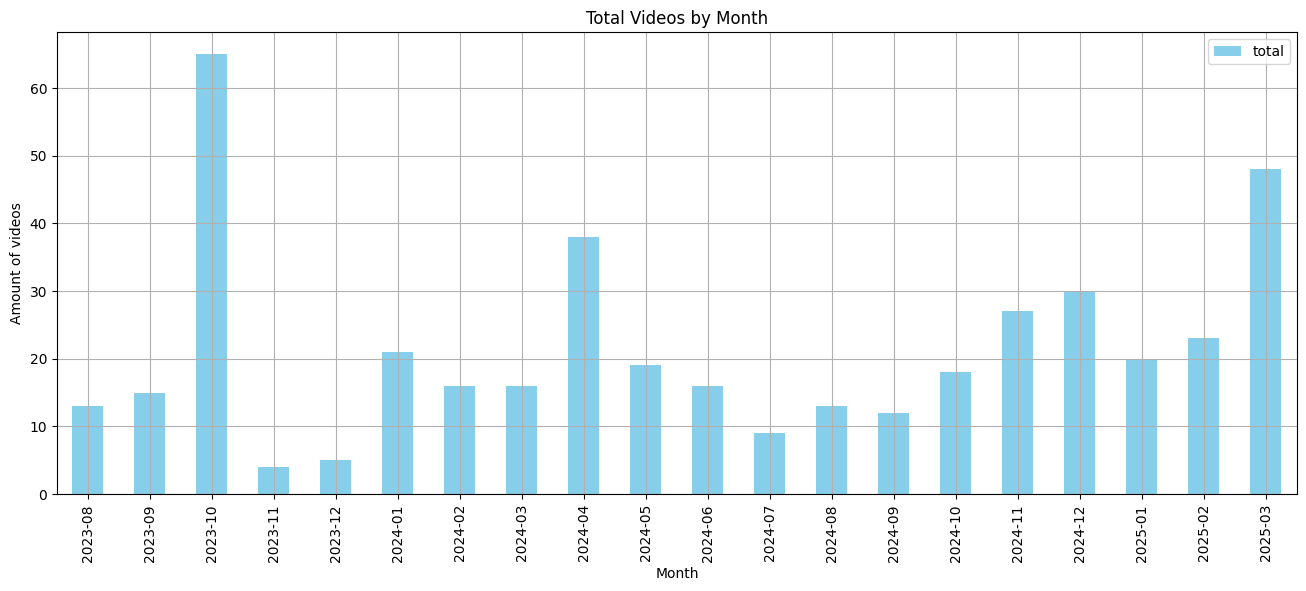

In [13]:
monthly_counts_df.plot.bar(y='total', figsize=(16, 6), title='Total Videos by Month', xlabel='Month', ylabel='Amount of videos', grid=True, color='skyblue')

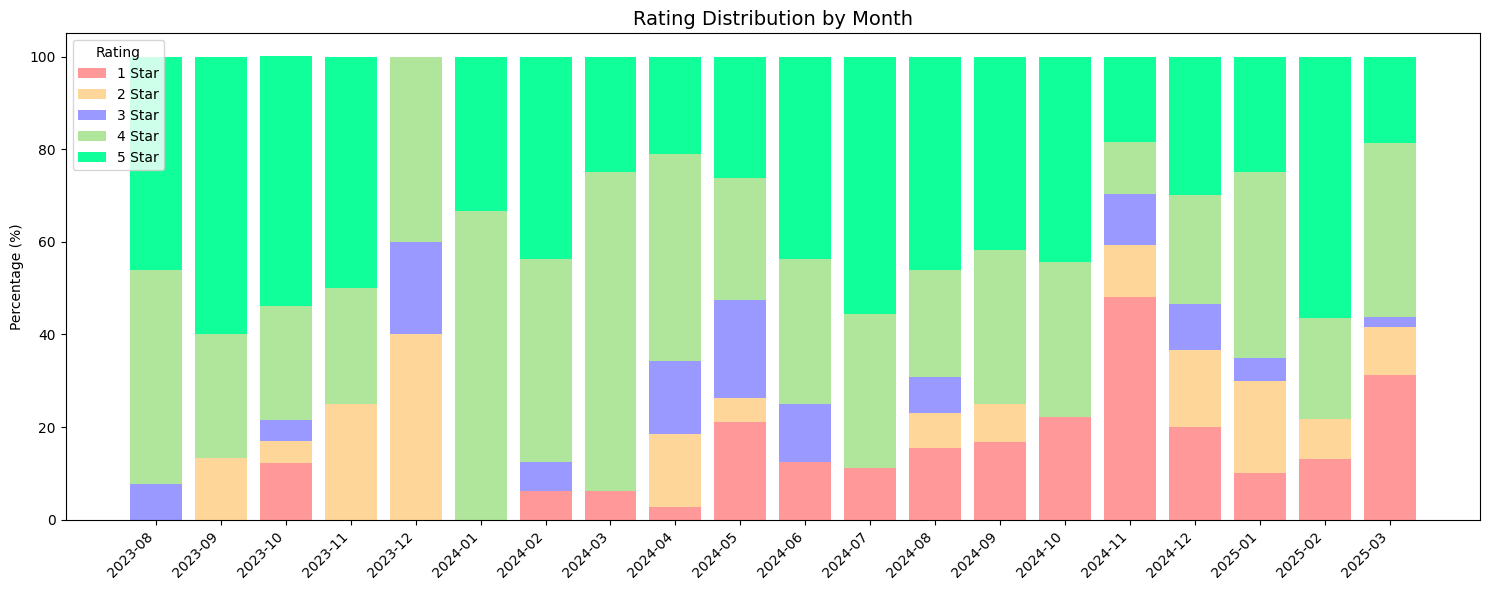

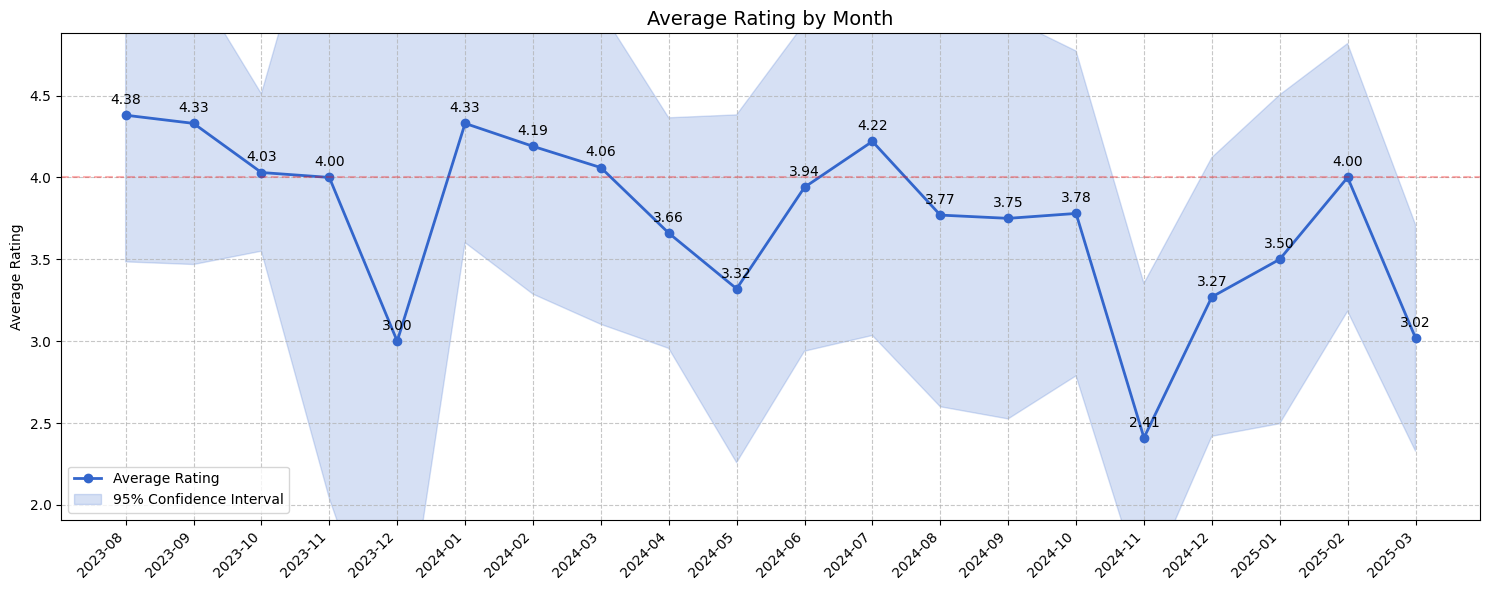

In [14]:
visualize_rating_percentages2(monthly_counts_df)

In [13]:
def create_topic_visualizations(df_in):
    """
    Create visualizations for topic percentages (total and per month)
    
    Parameters:
    df_in: DataFrame with columns topic (lists of topics), video_id, date
    
    Returns:
    None (displays plots)
    """
    # Create a copy to avoid modifying the input
    df = df_in.copy()
    
    # Ensure topic column contains lists; handle non-list or NaN values
    df['topic'] = df['topic'].apply(lambda x: x if isinstance(x, list) else [] if pd.isna(x) else [x])
    
    # Explode the topic column to have one topic per row
    df = df.explode('topic').reset_index(drop=True)
    
    # Remove rows with empty or invalid topics
    df = df[df['topic'].notna() & (df['topic'] != '')]
    
    # Add month column for grouping
    df['month'] = df['date'].dt.strftime('%Y-%m')
    
    # Figure 1: Total Percentage of Topics (Bar Chart)
    plt.figure(figsize=(15, 6))
    
    # Count total occurrences of each topic
    topic_counts = df['topic'].value_counts()
    total_topics = topic_counts.sum()
    topic_percentages = (topic_counts / total_topics * 100).round(1)
    
    # Sort from highest to lowest
    topic_percentages = topic_percentages.sort_values(ascending=False)
    
    # Get colors - one for each topic
    # colors = plt.cm.tab20(np.linspace(0, 1, len(topic_percentages)))

    # Define color scheme for 28 topics (combine tab20 and tab20c)
    # colors = np.vstack([plt.cm.tab20(np.linspace(0, 1, 20)), plt.cm.tab20b(np.linspace(0, 1, 20))])[:28]
    colors = np.vstack([plt.cm.tab20(np.linspace(0, 1, 20))])
    
    # Create bar chart
    ax = plt.bar(topic_percentages.index, topic_percentages, color=colors, edgecolor='white', linewidth=1)
    
    # Add percentage labels on top of bars (for bars with >= 5%)
    for bar in ax:
        height = bar.get_height()
        if height >= 5:
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', 
                     ha='center', va='bottom', fontsize=10)
    
    # Customize plot
    plt.title('Total Percentage of Topics', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Percentage of Topics by Month
    # Get topic counts per month
    monthly_topics = df.groupby(['month', 'topic']).size().unstack(fill_value=0)
    
    # Calculate percentages for each month
    monthly_percentages = monthly_topics.div(monthly_topics.sum(axis=1), axis=0) * 100
    
    # Sort months chronologically
    monthly_percentages = monthly_percentages.sort_index()
    
    # Get unique topics and sort by overall frequency
    all_topics = topic_counts.index.tolist()
    
    # Ensure all topics are in the monthly data (fill missing with zeros)
    for topic in all_topics:
        if topic not in monthly_percentages.columns:
            monthly_percentages[topic] = 0
    
    # Reorder columns by overall frequency
    monthly_percentages = monthly_percentages[all_topics]
    
    # Plot stacked bar chart
    plt.figure(figsize=(15, 10))
    
    # Plot stacked bars
    ax = monthly_percentages.plot(kind='bar', stacked=True, figsize=(18, 8), 
                                 color=colors, width=0.8)
    
    # Add labels and title
    plt.title('Percentage of Topics by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, labels=['%.1f%%' % x if x >= 5 else '' for x in container.datavalues], 
                    label_type='center')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Topic Trends Over Time (Line Chart)
    plt.figure(figsize=(15, 6))
    
    # Get top 4 topics for clarity
    top_topics = topic_counts.nlargest(3).index.tolist()
    
    # Plot line for each top topic
    for topic in top_topics:
        if topic in monthly_percentages.columns:
            plt.plot(monthly_percentages.index, monthly_percentages[topic], 
                    marker='o', linewidth=2, label=topic)
    
    plt.title('Trend of Top 3 Topics Over Time', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Topic')
    
    plt.tight_layout()
    plt.show()

In [15]:
def create_topic_visualizations_2(df_in):
    """
    Create visualizations for topic percentages with confidence intervals.
    
    Parameters:
    df_in: DataFrame with columns topic (lists of topics), video_id, date
    
    Returns:
    None (displays plots)
    """
    df = df_in.copy()

    df['month'] = df['date'].dt.strftime('%Y-%m')

    # Topic counts and percentages
    topic_counts = df['topic'].value_counts()
    total = topic_counts.sum()
    topic_percentages = (topic_counts / total * 100)

    # Standard error and 95% confidence interval
    z = norm.ppf(0.975)  # z-score for 95% CI
    se = np.sqrt((topic_percentages / 100) * (1 - topic_percentages / 100) / total) * 100
    ci = z * se

    # Sort values
    topic_percentages = topic_percentages.sort_values(ascending=False)
    ci = ci[topic_percentages.index]  # align CIs with sorted topics

    # Plotting
    plt.figure(figsize=(15, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(topic_percentages)))
    bars = plt.bar(topic_percentages.index, topic_percentages, yerr=ci, color=colors,
                   edgecolor='black', capsize=5, linewidth=1, ecolor='#424242', width=0.5)

    # Labels
    for bar, height in zip(bars, topic_percentages):    
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, height, f'{height:.1f}%', 
         ha='right', va='bottom', fontsize=10)
        
    

    plt.title('Total Percentage of Topics', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(handles=[mpatches.Patch(color='#424242', label='95% Confidence Intervals')], loc='upper right', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


In [17]:
df_sentiment_grouped = df_sentiment.explode('topic').reset_index(drop=True)

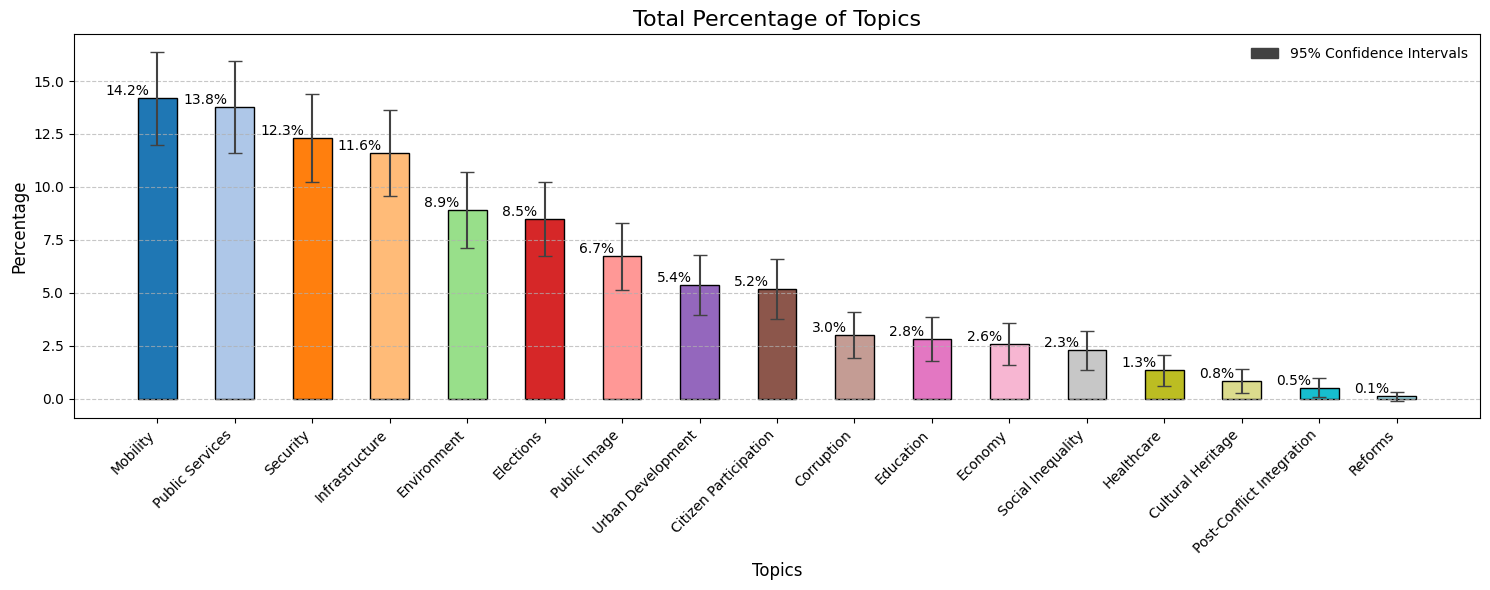

In [18]:
create_topic_visualizations_2(df_sentiment_grouped[['topic', 'score', 'video_id', 'date']])

In [19]:
def create_topic_vs_score_visualizations(df: pd.DataFrame) -> None:
    """
    Create improved visualizations for topic vs score.
    
    Parameters:
    df: DataFrame with columns 'topic' (string), 'score', and 'video_id'
    
    Returns:
    None (displays plots)
    """
    # Create a copy to avoid modifying input
    df_copy = df.copy()

    # Group by topic to compute statistics
    topic_summary = df_copy.groupby('topic').agg(
        average_score=('score', 'mean'),
        std_score=('score', 'std'),
        total_videos=('video_id', 'nunique')
    ).reset_index()

    # Calculate standard error and 95% CI
    topic_summary['standard_error'] = topic_summary['std_score'] / np.sqrt(topic_summary['total_videos'])
    topic_summary['ci_95'] = 1.96 * topic_summary['standard_error']

    # Sort by average_score (descending)
    topic_summary = topic_summary.sort_values('average_score', ascending=False)

    # Define colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(topic_summary)))

    # Create figure
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plot bars with CI error bars
    bars = ax1.bar(
        topic_summary['topic'],
        topic_summary['average_score'],
        yerr=topic_summary['ci_95'],  # 95% Confidence Intervals
        capsize=5,
        color=colors,
        linewidth=1.5,
        alpha=0.8,
        width=0.4,
        edgecolor='black',
        ecolor='#424242'
    )

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2 - 0.1,
            height + 0.05,
            f'{height:.2f}',
            ha='right',
            va='bottom',
            fontsize=12
        )

    # Customize plot
    ax1.set_title('Average Video Score by Topic', fontsize=16, pad=5)
    ax1.set_ylabel('Average Score (1-5)', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_xticks(range(len(topic_summary['topic'])))
    ax1.set_xticklabels(topic_summary['topic'], rotation=45, ha='right', fontsize=13)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 5)

    # Add legend for CI
    plt.legend(handles=[mpatches.Patch(color='#424242', label='95% Confidence Intervals')], loc='upper right', fontsize=10, frameon=False)
    # Final layout
    plt.tight_layout()
    plt.show()

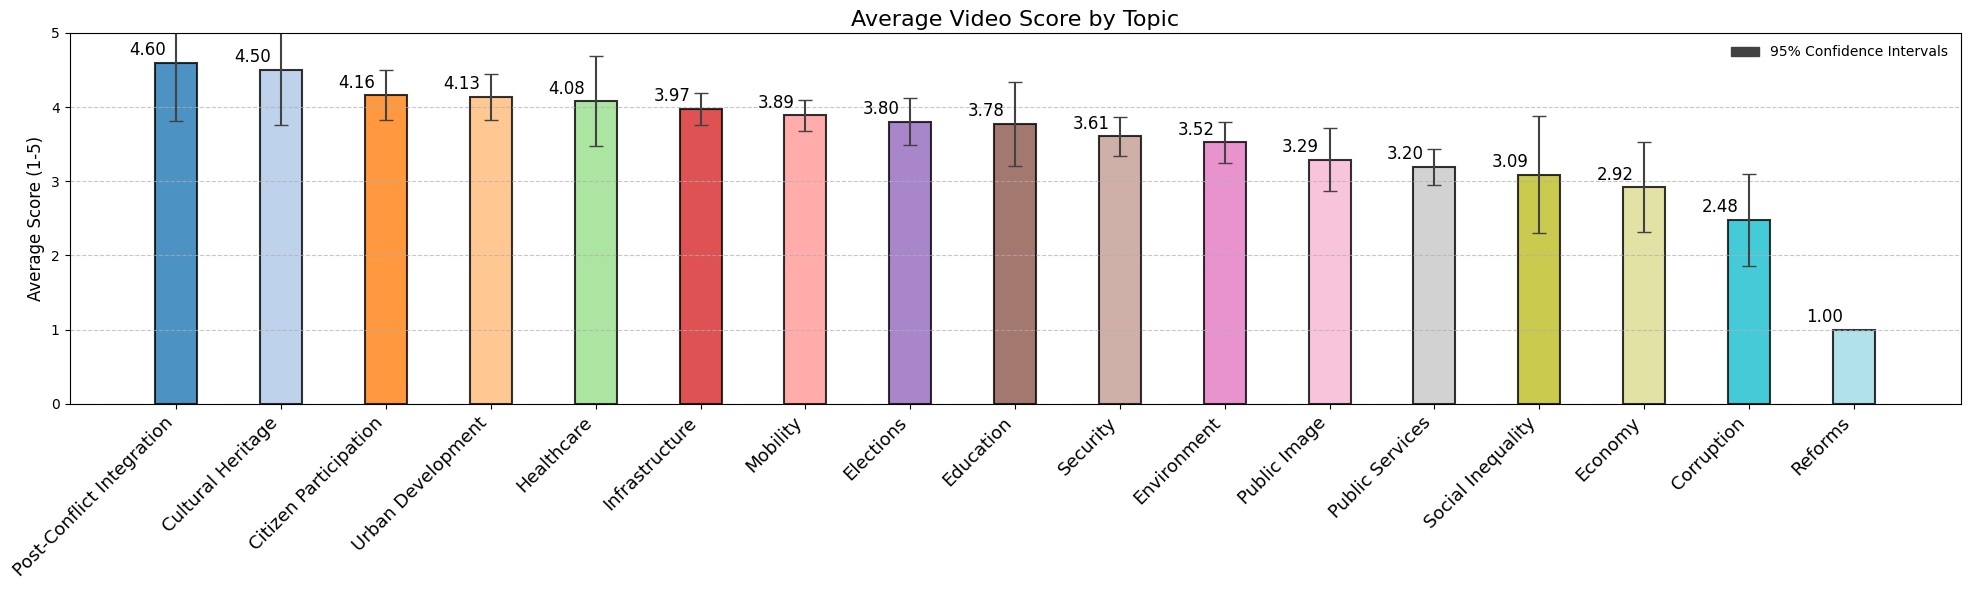

In [20]:
create_topic_vs_score_visualizations(df_sentiment_grouped[['topic', 'score', 'video_id']])

In [57]:
def plot_topic_knowledge_graph(df: pd.DataFrame, topic_col: str = 'topic') -> None:
    """
    Plot a knowledge graph of topics based on co-occurrence and its adyacent matrix.

    Parameters:
    - df: DataFrame containing a column with lists of topics
    - topic_col: Name of the column containing topic lists (default: 'topic')

    Returns:
    - None (displays the graph)
    """

    if topic_col not in df.columns:
        raise ValueError(f"Column '{topic_col}' not found in DataFrame.")
    
    
    df_sentiment_grouped = df.copy()

    # Flatten all topics and count frequency
    all_topics = [topic for sublist in df_sentiment_grouped[topic_col] for topic in sublist]
    topic_counts = Counter(all_topics)
    unique_topics = list(topic_counts.keys())

    # Build graph
    G = nx.Graph()

    # 2. Determine node sizes
    base_node_size = 15          # Minimum size for any node (for a topic appearing once)
    increment_per_occurrence = 0.5 # How much the size increases for each additional occurrence
    node_size_cap = 150       # Maximum size for any node

    # Add nodes with frequency-based size
    for topic, count in topic_counts.items():
        t_zise = min(base_node_size + (count * increment_per_occurrence), node_size_cap)
        G.add_node(topic, size=t_zise)

    # Add edges based on co-occurrence
    for topics in df_sentiment_grouped[topic_col]:
        
        for pair in combinations(topics, 2):
            # print(pair)
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]['weight'] += 1
            else:
                G.add_edge(*pair, weight=1)


    # Layout
    # pos = nx.spring_layout(G, seed=42)
    pos = nx.spring_layout(G, k=6, seed=50, iterations=50)

    # Assign unique color per node using a colormap
    cmap = cm.get_cmap('tab20', len(unique_topics))
    topic_color_map = {topic: cmap(i) for i, topic in enumerate(unique_topics)}
    node_colors = [topic_color_map[node] for node in G.nodes]

    # Scaled sizes and edge widths
    node_sizes = [G.nodes[n]['size'] * 130 for n in G.nodes]
    edge_widths = [G[u][v]['weight'] * 0.3 for u, v in G.edges]

    # Plot
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, edgecolors='black')
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, edge_color='gray')
    # nx.draw_networkx_edges(G, pos, width=1, alpha=0.60, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8.5, font_color='black')

    plt.title("Knowledge Graph of Topics", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


    # Collect all unique topics
    # all_grouped_topics = sorted({group["topic"] for group in grouped_topic_list})
    topic_index = {topic: i for i, topic in enumerate(unique_topics)}
    
    # Create empty adjacency matrix
    size = len(unique_topics)
    adjacency = np.zeros((size, size), dtype=int)

    # Fill adjacency matrix based on co-occurrence
    for topics in df_sentiment_grouped[topic_col]:
        for t1, t2 in combinations(topics, 2):
            i, j = topic_index[t1], topic_index[t2]
            adjacency[i][j] += 1
            adjacency[j][i] += 1  # symmetric

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(adjacency, cmap='Blues')

    # Tick labels
    ax.set_xticks(np.arange(size))
    ax.set_yticks(np.arange(size))
    ax.set_xticklabels(unique_topics, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(unique_topics, fontsize=10)

    # Annotate values
    for i in range(size):
        for j in range(size):
            if adjacency[i, j] > 0:
                ax.text(j, i, adjacency[i, j], ha='center', va='center', color='black', fontsize=9)

    ax.set_title("Topic Adjacency Matrix", fontsize=14, pad=10)
    plt.colorbar(im, ax=ax, fraction=0.045)
    plt.tight_layout()
    plt.show()

C:\Users\ecmar\AppData\Local\Temp\ipykernel_3912\761214711.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_topics))


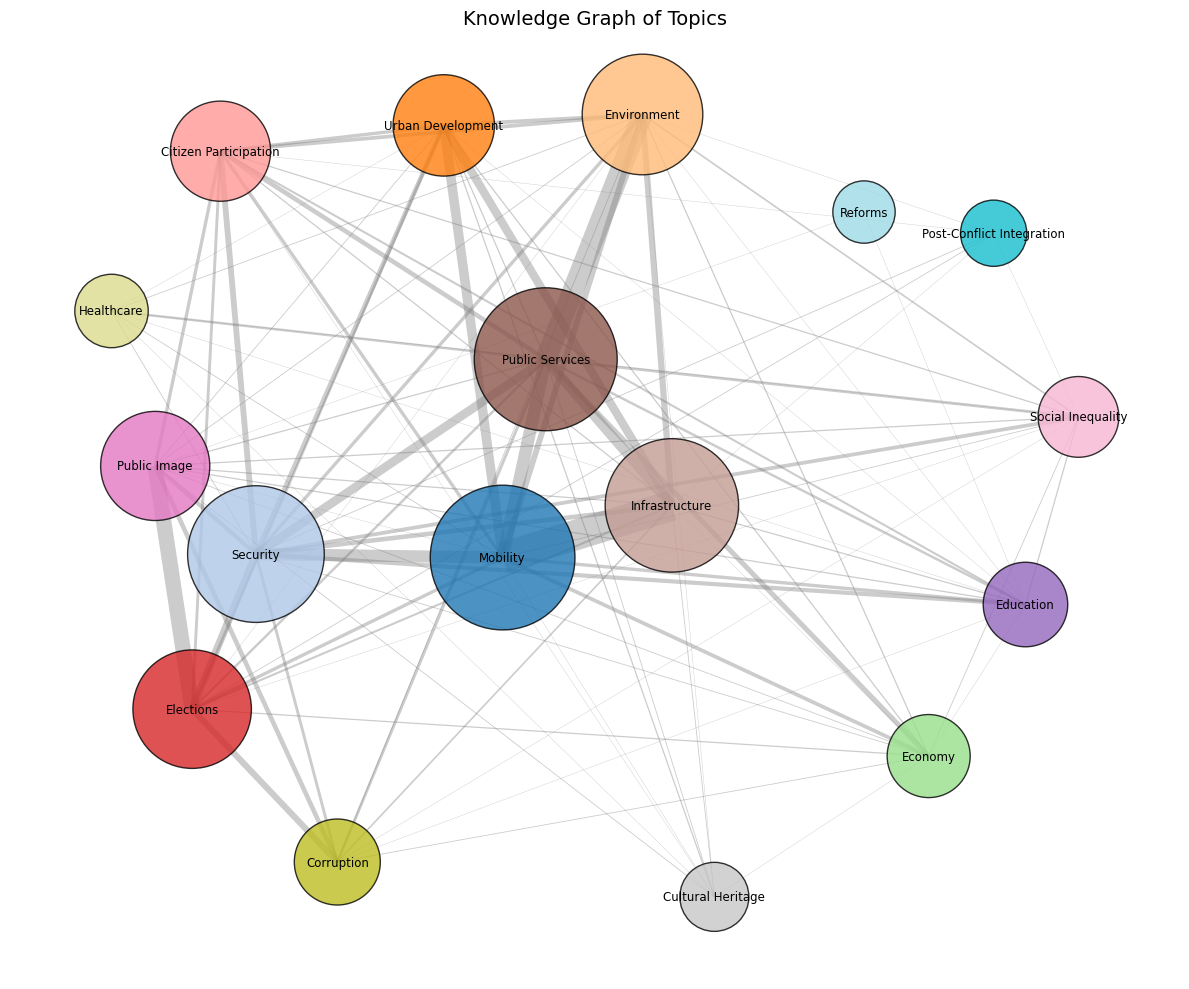

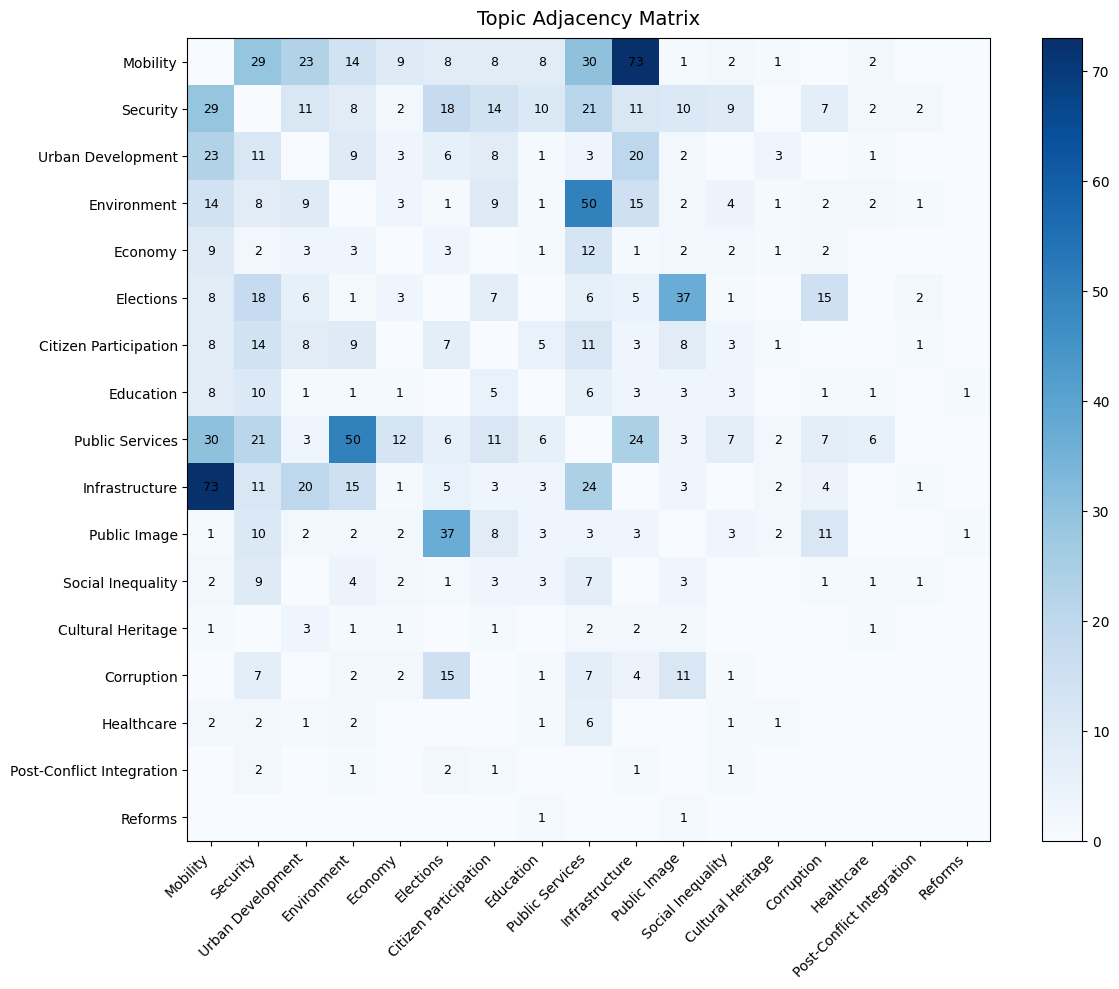

In [58]:
plot_topic_knowledge_graph(df_sentiment[['topic']], topic_col='topic')

#### Videos data vs Polls

In [64]:
polls_data = {
    'date': ['2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'],
    'Approved_percent': [54,56,59,53,47,49,50,51,52,49,47,45,44,47]
}
df_polls = pd.DataFrame(polls_data)

In [60]:
df_approval = monthly_counts_df.copy()

In [61]:
df_approval["Approved_percent"] = df_approval["4_percent"] + df_approval["5_percent"]

In [62]:
def create_polls_vs_sentiment_visualizations(df_approval: pd.DataFrame, df_polls: pd.DataFrame, min_month:str, max_month:str) -> None:
    """
    Create visualizations for polls vs sentiment, with 95% CI for TikTok line only.
    
    Parameters:
    df_approval: DataFrame with columns 'date', 'Approved_percent', 'total'
    df_polls: DataFrame with columns 'date', 'Approved_percent'
    
    Returns:
    None (displays plots)
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # X-axis
    x_data = range(len(df_polls['date']))

    ax1.set_title('Approval Percentage by Month', fontsize=14)
    ax1.set_ylabel('Approval (%)')
    ax1.set_xticks(x_data)
    ax1.set_xticklabels(df_polls['date'], rotation=45, ha='right')
    ax1.set_ylim(
        min(df_approval['Approved_percent'].min(), df_polls['Approved_percent'].min()) - 5,
        max(df_approval['Approved_percent'].max(), df_polls['Approved_percent'].max()) + 5
    )
    ax1.grid(True, linestyle='--', alpha=0.7)

    df_tiktok = df_approval.loc[min_month:max_month]

    # ---- CI for TikTok approval ----
    p = df_tiktok['Approved_percent'] / 100
    n = df_tiktok['total']
    se = np.sqrt(p * (1 - p) / n) * 100  # scale to percentage
    ci = 1.96 * se

    # Plot TikTok line with CI
    ax1.plot(x_data, df_tiktok['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--', label='TikTok')
    print(len(df_tiktok['Approved_percent']))
    print(len(ci))
    ax1.fill_between(
        x_data,
        df_tiktok['Approved_percent'] - ci,
        df_tiktok['Approved_percent'] + ci,
        color='#3366CC',
        alpha=0.2,
        label='95% Confidence Interval (TikTok)'
    )

    # Plot Polls line (no CI)
    ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--', label='Polls')

    ax1.legend(title='Source')
    plt.tight_layout()
    plt.show()

14
14


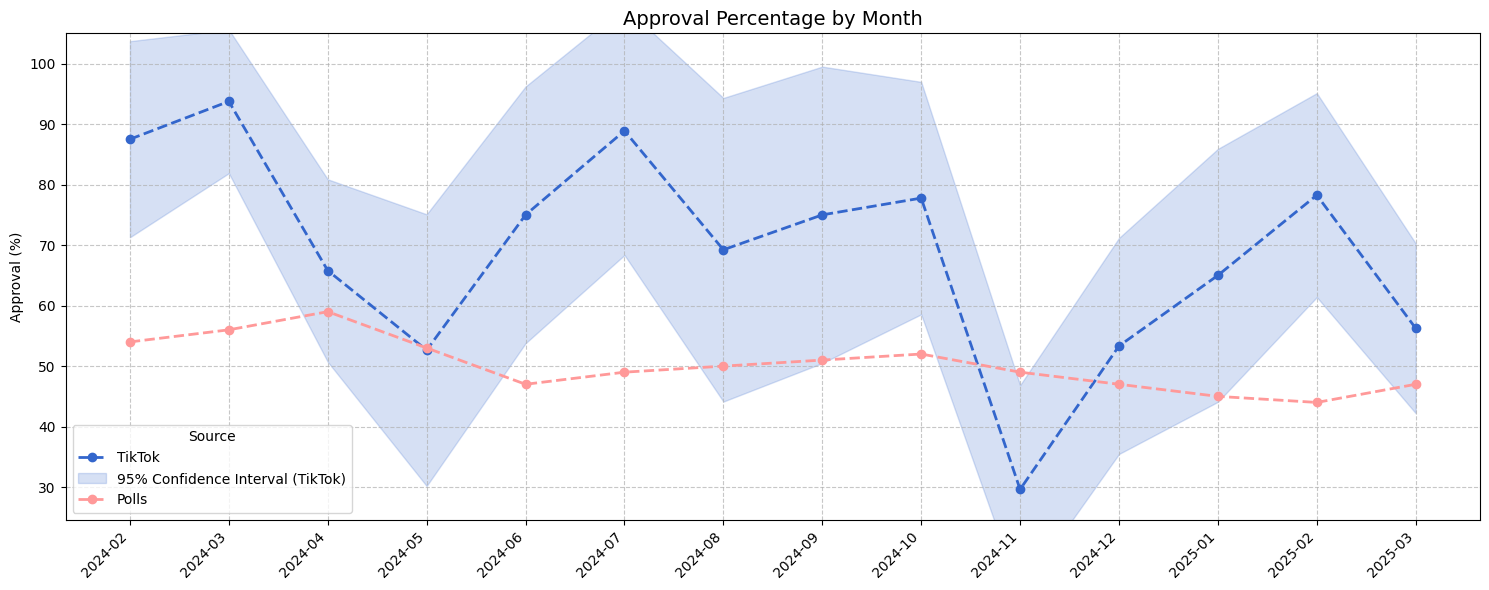

In [65]:
create_polls_vs_sentiment_visualizations(df_approval, df_polls,'2024-02','2025-03')